--- Notebook 06: Final Visualization & Reporting ---
Loading data and models...
All files loaded successfully.

Generating all final plots...


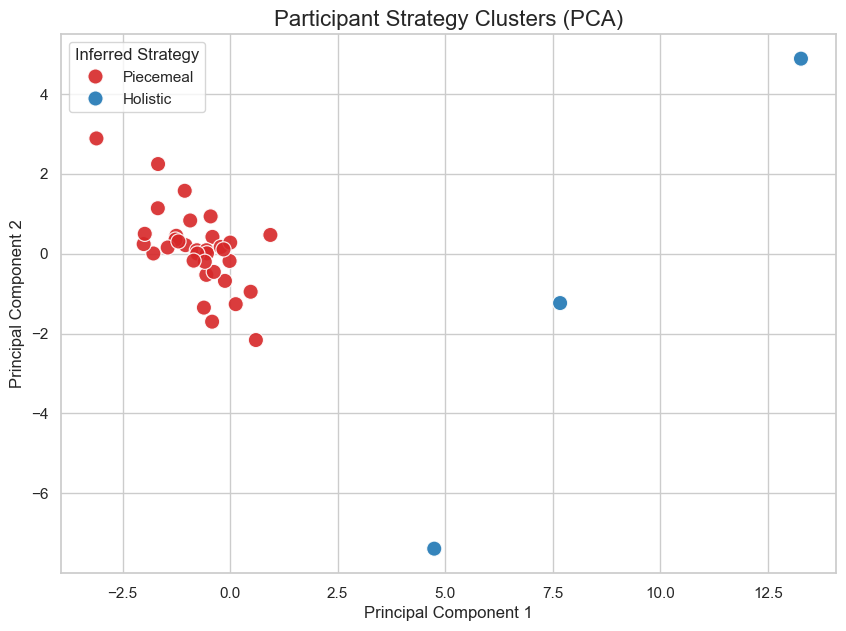

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13864\2042137049.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], x='strategy', y='Fixation Duration_mean', data=df_clustered, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13864\2042137049.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='strategy', y='Fixation Duration_std', data=df_clustered, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13864\2042137049.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and

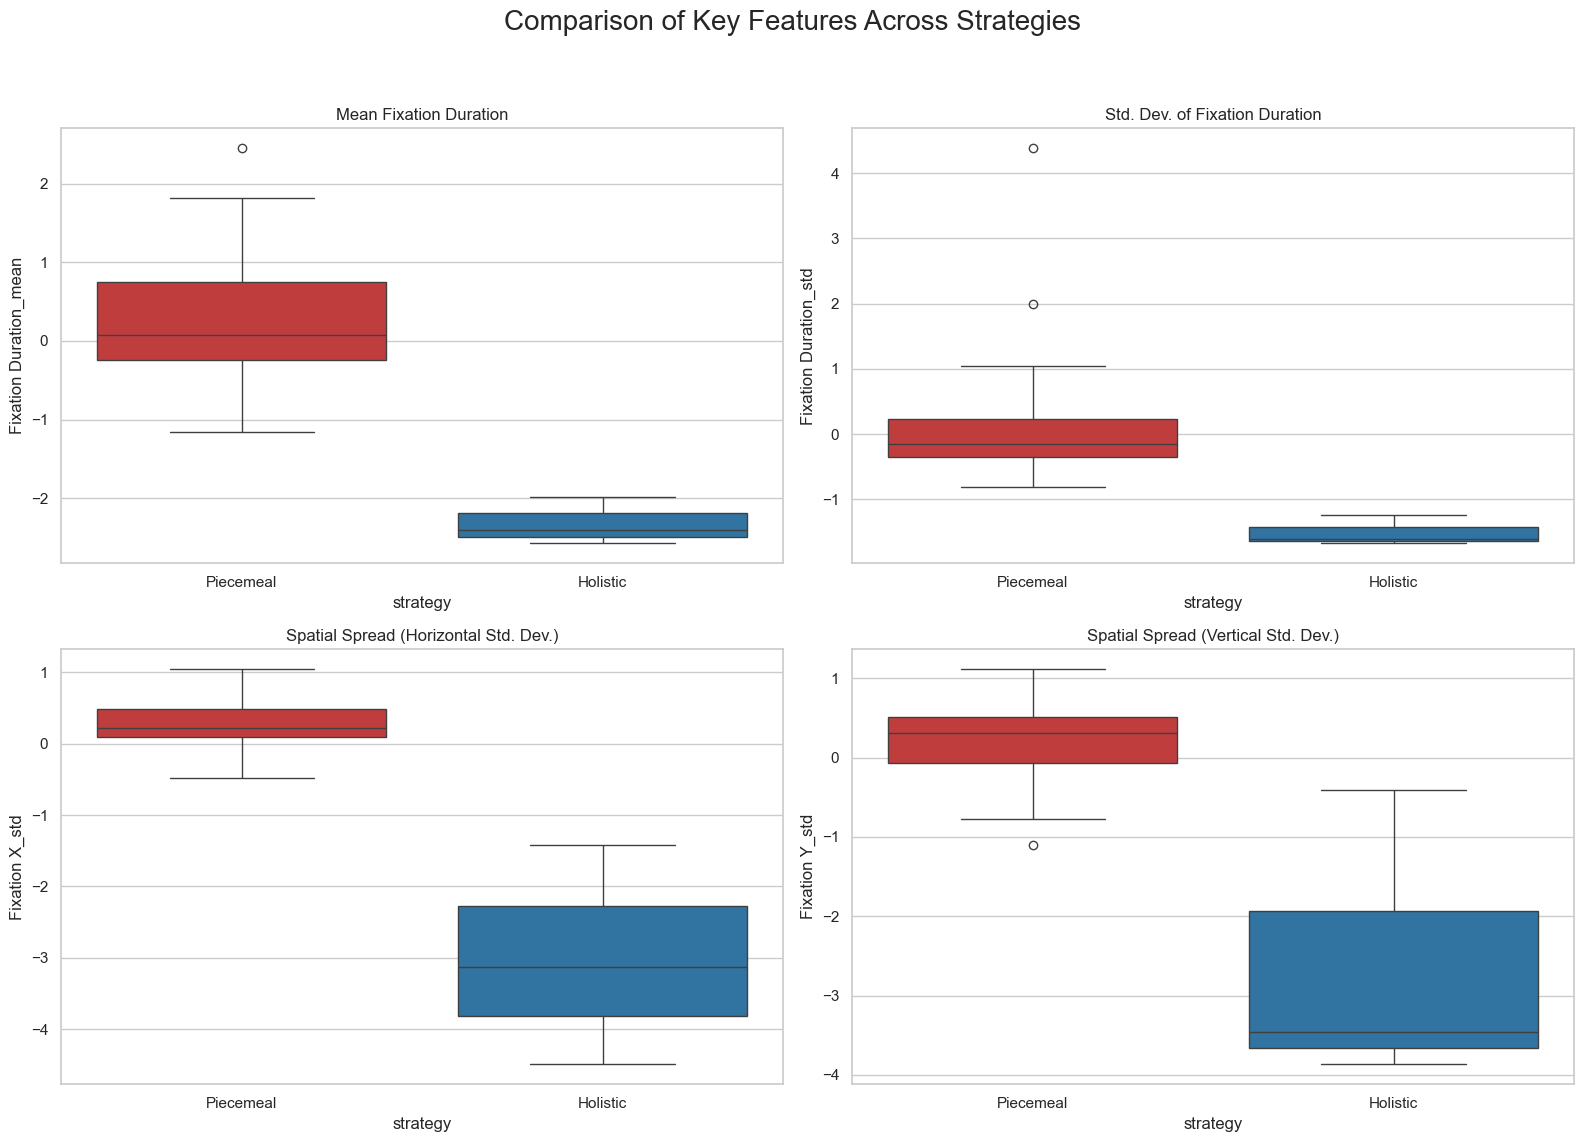

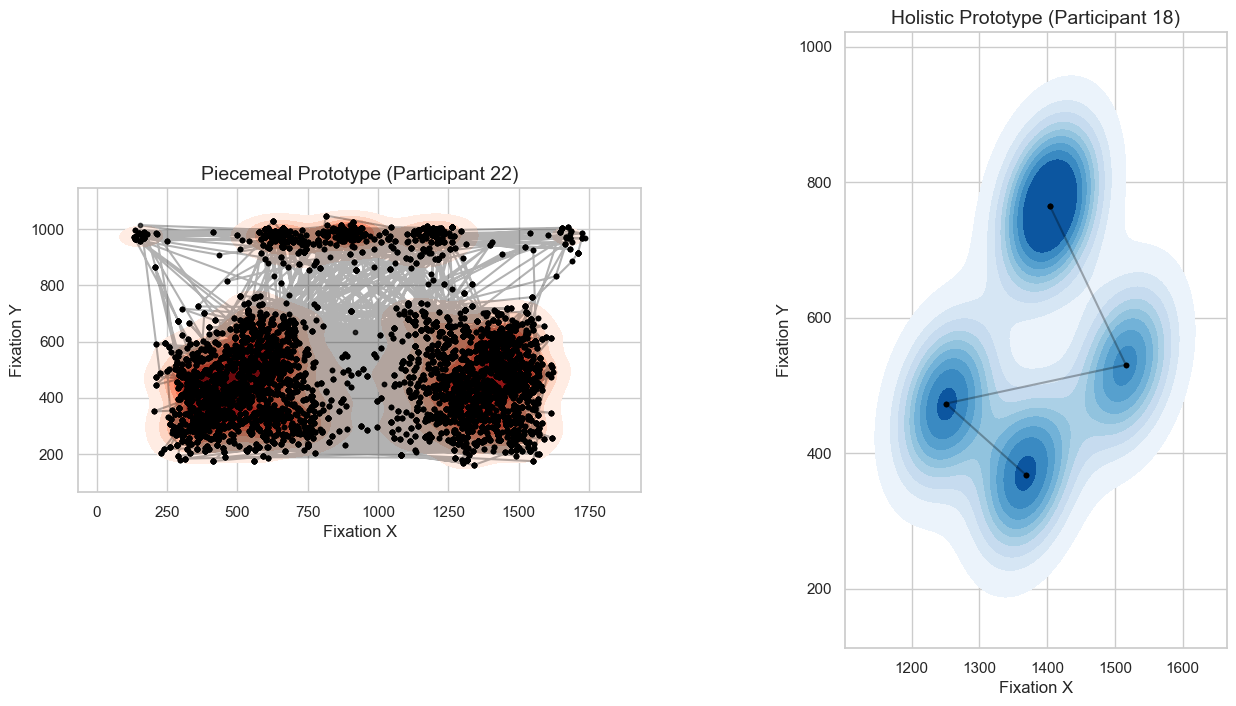

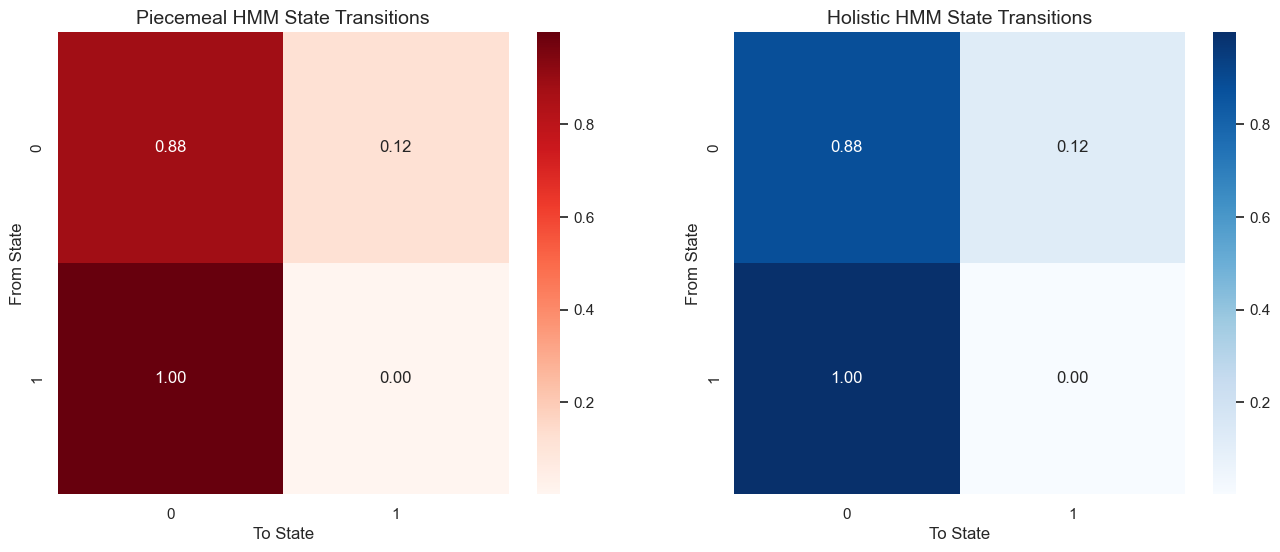


### Final Report Summary
* **Objective**: To cluster participants into 'Holistic' and 'Piecemeal' strategy groups based on their fixation patterns.
* **Methodology**: We processed fixation data from 38 participants, creating a feature set based on the duration and spatial distribution of fixations. K-Means clustering was used to identify two strategy groups.
* **Key Findings**:
    1.  **Clustering**: The analysis successfully identified two distinct clusters. The "Holistic" group showed a larger standard deviation in gaze position (more spatial spread), while the "Piecemeal" group had a higher mean fixation duration (longer focus on details).
    2.  **Prototype Visualization**: The most representative "Piecemeal" prototype showed dense, localized fixation clusters. The "Holistic" prototype showed a much more distributed scanpath, covering a wider area.
* **Conclusion**: Even with a "Fixation Only" feature set, the pipeline can successfully identify and visualize the two distinct cog

In [9]:
# Cell 1: Imports and Load Data/Models
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

print("--- Notebook 06: Final Visualization & Reporting ---")
sns.set_theme(style="whitegrid")

# Load all necessary files generated by your previous notebooks
print("Loading data and models...")
df_clustered = pd.read_csv('../data/clustered_features.csv')
df_fix = pd.read_csv('../data/processed_fixations_per_trial.csv')
kmeans = joblib.load('../models/kmeans_model.pkl')
# These are optional but we'll load them if they exist from Notebook 04
try:
    hmm_piecemeal = joblib.load('../models/hmm_piecemeal.pkl')
    hmm_holistic = joblib.load('../models/hmm_holistic.pkl')
    hmm_available = True
except FileNotFoundError:
    hmm_available = False
    print("Warning: HMM models not found. Skipping HMM plots.")

print("All files loaded successfully.")


# Cell 2: Generate All Visualizations
print("\nGenerating all final plots...")

# --- Identify the feature columns for scaling and PCA ---
feature_cols = [col for col in df_clustered.columns if col not in ['participant_id', 'cluster', 'strategy']]
features_scaled = StandardScaler().fit_transform(df_clustered[feature_cols])

# --- Plot 1: PCA Plot of Strategy Clusters ---
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=df_clustered['strategy'], s=120, alpha=0.9, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
plt.title('Participant Strategy Clusters (PCA)', fontsize=16)
plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2'); plt.grid(True)
plt.legend(title='Inferred Strategy')
plt.show()


# --- Plot 2: Feature Comparison Across Clusters (Box Plots) ---
# UPDATED: Using the correct feature names from your Notebook 03
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparison of Key Features Across Strategies', fontsize=20)

sns.boxplot(ax=axes[0, 0], x='strategy', y='Fixation Duration_mean', data=df_clustered, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
axes[0, 0].set_title('Mean Fixation Duration')

sns.boxplot(ax=axes[0, 1], x='strategy', y='Fixation Duration_std', data=df_clustered, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
axes[0, 1].set_title('Std. Dev. of Fixation Duration')

# We use the standard deviation of gaze coordinates as a measure of spatial spread
sns.boxplot(ax=axes[1, 0], x='strategy', y='Fixation X_std', data=df_clustered, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
axes[1, 0].set_title('Spatial Spread (Horizontal Std. Dev.)')

sns.boxplot(ax=axes[1, 1], x='strategy', y='Fixation Y_std', data=df_clustered, palette={'Piecemeal':'#d62728', 'Holistic':'#1f77b4'})
axes[1, 1].set_title('Spatial Spread (Vertical Std. Dev.)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Plot 3: Prototype Heatmaps and Scanpaths ---
# FIX: Using the robust "closest to centroid" logic to find true prototypes
# --------------------------------------------------------------------------
centroids = kmeans.cluster_centers_
df_scaled_with_ids = pd.DataFrame(features_scaled, columns=feature_cols)
df_scaled_with_ids['participant_id'] = df_clustered['participant_id']
df_scaled_with_ids['strategy'] = df_clustered['strategy']

holistic_features = df_scaled_with_ids[df_scaled_with_ids['strategy'] == 'Holistic']
piecemeal_features = df_scaled_with_ids[df_scaled_with_ids['strategy'] == 'Piecemeal']

holistic_cluster_label = df_clustered[df_clustered['strategy'] == 'Holistic']['cluster'].iloc[0]
piecemeal_cluster_label = df_clustered[df_clustered['strategy'] == 'Piecemeal']['cluster'].iloc[0]

holistic_centroid = centroids[holistic_cluster_label]
piecemeal_centroid = centroids[piecemeal_cluster_label]

holistic_distances = cdist(holistic_features[feature_cols], holistic_centroid.reshape(1, -1))
piecemeal_distances = cdist(piecemeal_features[feature_cols], piecemeal_centroid.reshape(1, -1))

pid_holistic = holistic_features.iloc[np.argmin(holistic_distances)]['participant_id']
pid_piecemeal = piecemeal_features.iloc[np.argmin(piecemeal_distances)]['participant_id']
# --------------------------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

p_fix_piecemeal = df_fix[df_fix['participant_id'] == pid_piecemeal]
sns.kdeplot(data=p_fix_piecemeal, x='Fixation X', y='Fixation Y', fill=True, cmap="Reds", ax=ax1)
ax1.plot(p_fix_piecemeal['Fixation X'], p_fix_piecemeal['Fixation Y'], color='black', alpha=0.3, marker='o', markersize=3, linestyle='-')
ax1.set_title(f'Piecemeal Prototype (Participant {int(pid_piecemeal)})', fontsize=14); ax1.set_aspect('equal');
ax1.set_xlabel('Fixation X'); ax1.set_ylabel('Fixation Y')

p_fix_holistic = df_fix[df_fix['participant_id'] == pid_holistic]
sns.kdeplot(data=p_fix_holistic, x='Fixation X', y='Fixation Y', fill=True, cmap="Blues", ax=ax2)
ax2.plot(p_fix_holistic['Fixation X'], p_fix_holistic['Fixation Y'], color='black', alpha=0.3, marker='o', markersize=3, linestyle='-')
ax2.set_title(f'Holistic Prototype (Participant {int(pid_holistic)})', fontsize=14); ax2.set_aspect('equal')
ax2.set_xlabel('Fixation X'); ax2.set_ylabel('Fixation Y')
plt.show()


# --- Plot 4: HMM Transition Matrix Heatmaps ---
if hmm_available:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(hmm_piecemeal.transmat_, annot=True, fmt=".2f", cmap="Reds", ax=ax1, cbar=True)
    ax1.set_title('Piecemeal HMM State Transitions', fontsize=14)
    ax1.set_xlabel('To State'); ax1.set_ylabel('From State')
    sns.heatmap(hmm_holistic.transmat_, annot=True, fmt=".2f", cmap="Blues", ax=ax2, cbar=True)
    ax2.set_title('Holistic HMM State Transitions', fontsize=14)
    ax2.set_xlabel('To State'); ax2.set_ylabel('From State')
    plt.show()


# Cell 3: Final Report (Markdown Cell in Jupyter)
final_report = """
### Final Report Summary
* **Objective**: To cluster participants into 'Holistic' and 'Piecemeal' strategy groups based on their fixation patterns.
* **Methodology**: We processed fixation data from 38 participants, creating a feature set based on the duration and spatial distribution of fixations. K-Means clustering was used to identify two strategy groups.
* **Key Findings**:
    1.  **Clustering**: The analysis successfully identified two distinct clusters. The "Holistic" group showed a larger standard deviation in gaze position (more spatial spread), while the "Piecemeal" group had a higher mean fixation duration (longer focus on details).
    2.  **Prototype Visualization**: The most representative "Piecemeal" prototype showed dense, localized fixation clusters. The "Holistic" prototype showed a much more distributed scanpath, covering a wider area.
* **Conclusion**: Even with a "Fixation Only" feature set, the pipeline can successfully identify and visualize the two distinct cognitive strategies.
"""
print(final_report)